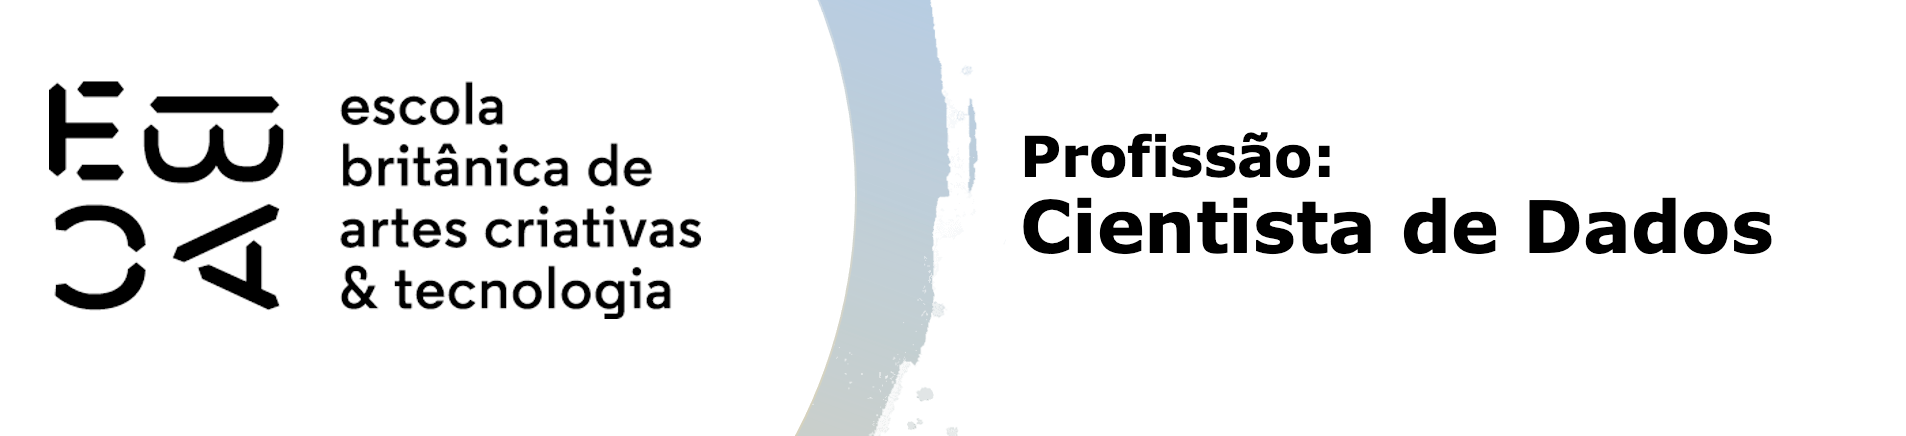

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

In [5]:

from ydata_profiling import ProfileReport

In [6]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV  


In [12]:
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import ks_2samp

In [14]:
df = pd.read_feather('../projeto_credit_scoring/credit_scoring.ftr')

In [16]:
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [18]:
df['data_ref'].unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00',
 '2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 15, dtype: datetime64[ns]

In [158]:
df_val = df[df['data_ref'] >= pd.Timestamp('2016-01-01 00:00:00')]
df_val

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,True
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,False
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,False
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,False
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,2016-03-01,13689,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,2016-03-01,7000,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,NaN,1.0,1389.39,False
749997,2016-03-01,14023,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,2016-03-01,2396,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [22]:
df_train = df.drop(df_val.index)
df_train

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,2015-12-01,2205,F,S,N,0,Assalariado,Médio,União,Casa,47,23.690411,2.0,11009.92,False
599996,2015-12-01,1266,M,S,N,1,Empresário,Superior completo,Casado,Casa,31,3.756164,3.0,4472.60,False
599997,2015-12-01,13085,F,N,N,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,5117.17,True
599998,2015-12-01,10964,F,N,N,0,Assalariado,Superior completo,Casado,Casa,40,12.939726,2.0,2885.45,True


In [24]:
df_train['data_ref'].unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00']
Length: 12, dtype: datetime64[ns]

In [122]:
df_train.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'possui_filho'],
      dtype='object')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [29]:
df.shape

(750000, 15)

In [31]:
for date in df['data_ref'].unique():
    num_linhas = len(df[df['data_ref'] == date])
    print(f"Número de linhas no mês {date}: {num_linhas}")

Número de linhas no mês 2015-01-01 00:00:00: 50000
Número de linhas no mês 2015-02-01 00:00:00: 50000
Número de linhas no mês 2015-03-01 00:00:00: 50000
Número de linhas no mês 2015-04-01 00:00:00: 50000
Número de linhas no mês 2015-05-01 00:00:00: 50000
Número de linhas no mês 2015-06-01 00:00:00: 50000
Número de linhas no mês 2015-07-01 00:00:00: 50000
Número de linhas no mês 2015-08-01 00:00:00: 50000
Número de linhas no mês 2015-09-01 00:00:00: 50000
Número de linhas no mês 2015-10-01 00:00:00: 50000
Número de linhas no mês 2015-11-01 00:00:00: 50000
Número de linhas no mês 2015-12-01 00:00:00: 50000
Número de linhas no mês 2016-01-01 00:00:00: 50000
Número de linhas no mês 2016-02-01 00:00:00: 50000
Número de linhas no mês 2016-03-01 00:00:00: 50000


In [64]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
df2 = df.copy()
df2['tempo_emprego_norm'] = sc_X.fit_transform(df2[['tempo_emprego']])
df2['renda_norm'] = sc_X.fit_transform(df2[['renda']])

In [26]:
# para a finalização do projeto, vou fazer diretamente no streamlit e interativo
# aqui usei o ydata_profiling apenas pro objetivo da atividade

prof = ProfileReport(df, explorative=True, minimal=True)
prof

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
prof.to_file("relatorio_univariada_mod37.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [118]:
print(df['mau'].sum()/len(df))

0.07819066666666667


In [69]:
variaveis = ['sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau']

### Sobre a univariada



- Variável "maus" desbalanceada: apenas cerca de 8% são classificados "maus", o que precisa ser considerado ao realizar a modelagem;
- tempo_emprego tem 125957 (16.8%) missings
- qtd_filhos: 69% de zeros. O que é normal, mas indica uma variável pouco explicativa. Como o modelo poderia diferenciar bastante 2 para 3 filhos? Uma solução seria agrupar: possui_filho (uma boobleana mais explicativa).

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [ ]:
# para a finalização do projeto, vou fazer diretamente no streamlit e interativo
# por isso não vou ser exaustivo aqui

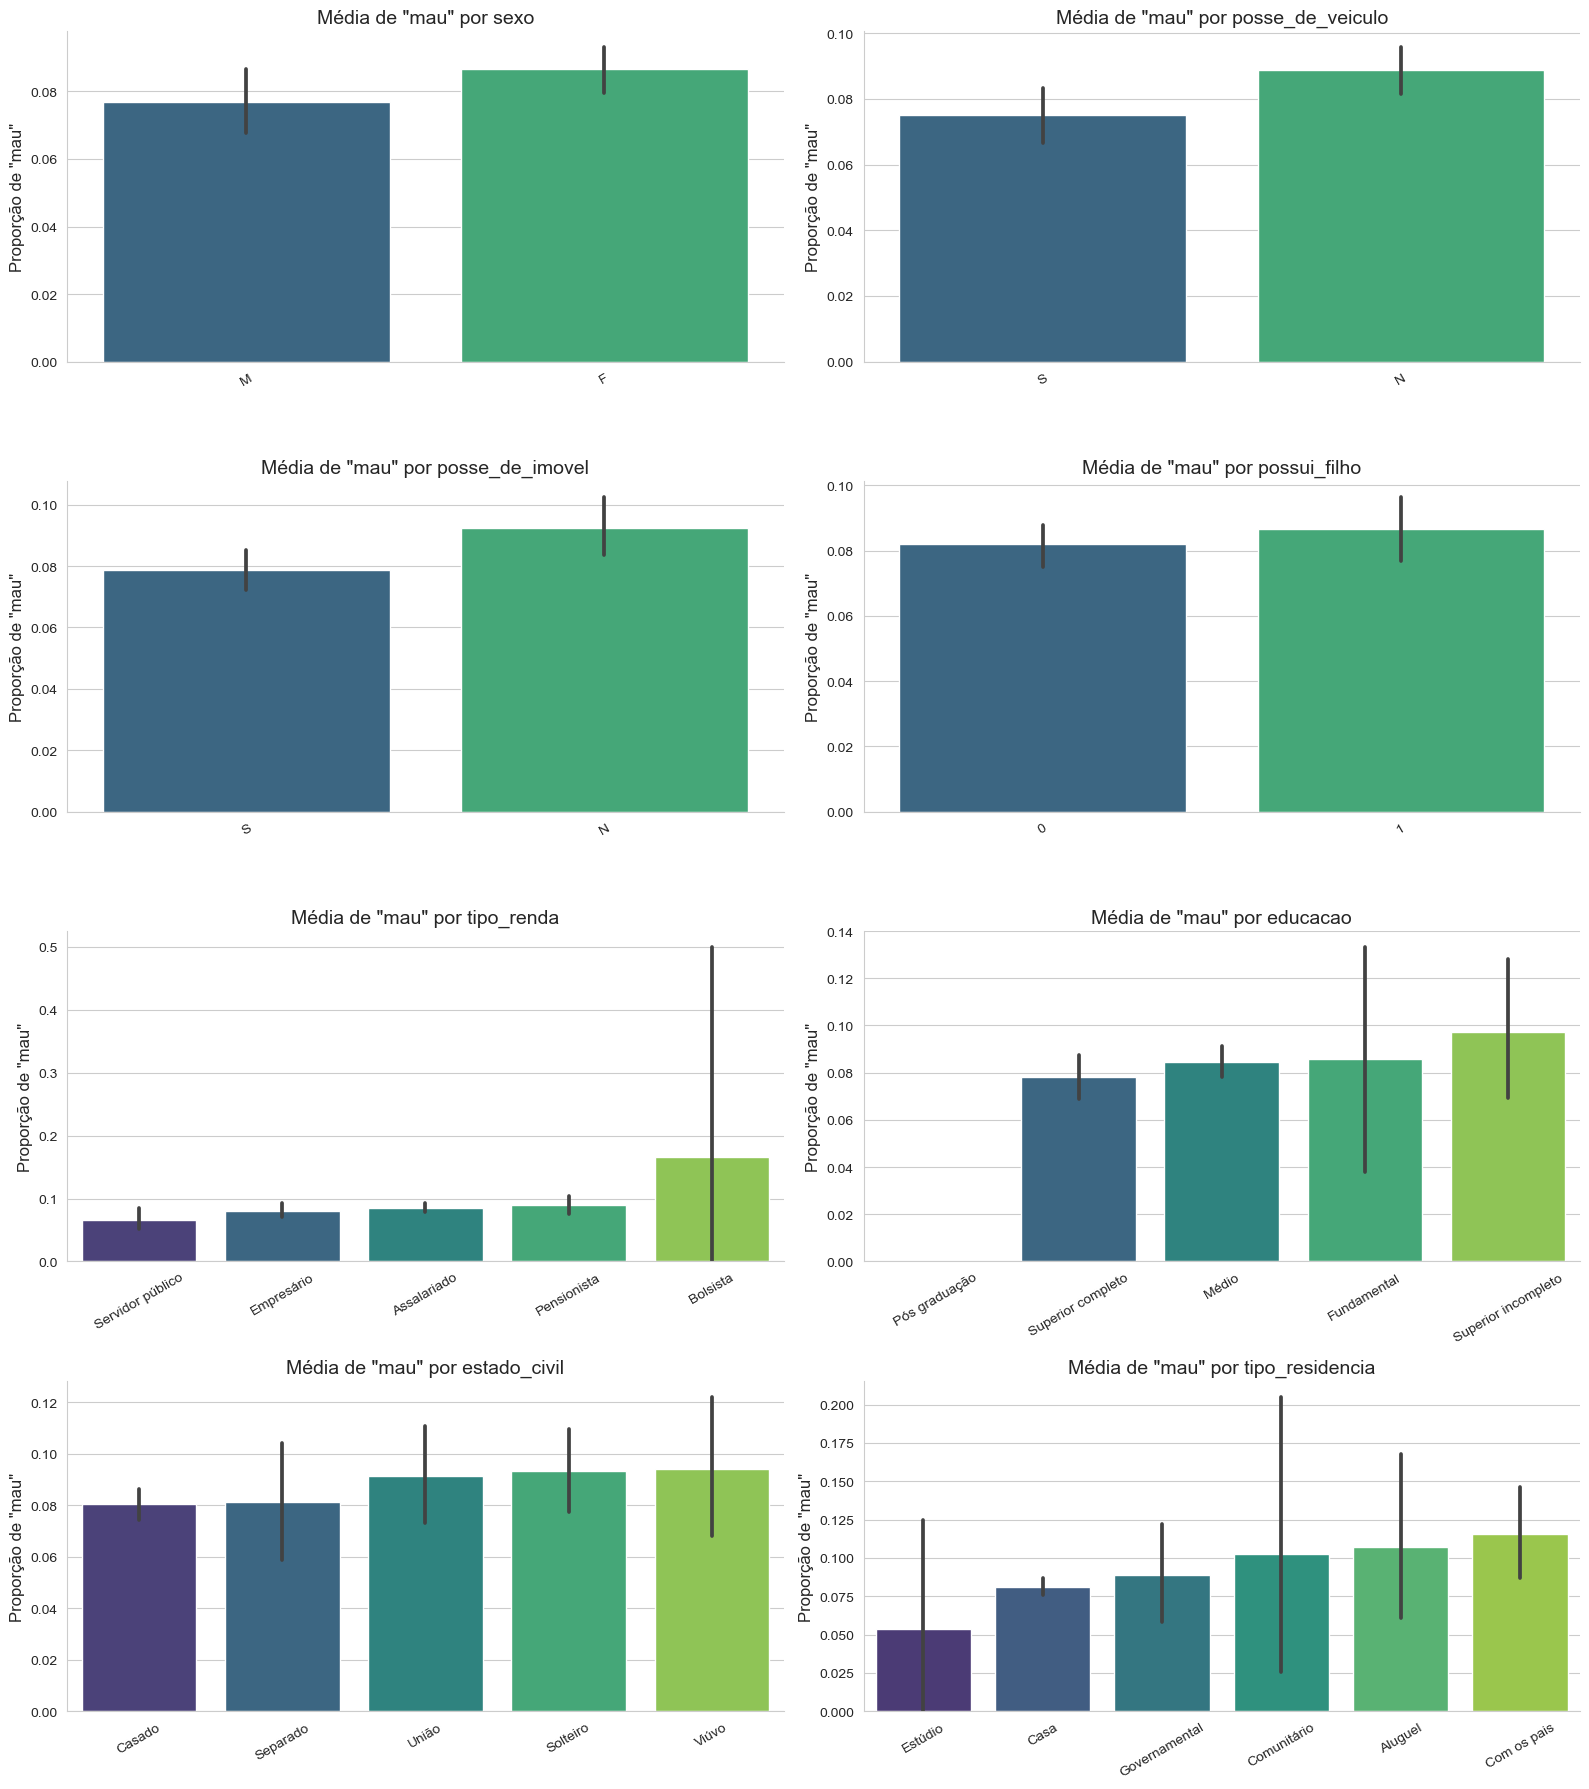

In [129]:
#categóricas
#médias por grupo
sns.set_style("whitegrid")  

df_sample = df.sample(10000, random_state=42)

categorical_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'possui_filho',
                    'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

fig, ax = plt.subplots(4, 2, figsize=(16, 18))  
ax = ax.flatten() 

for i, var in enumerate(categorical_vars):
    order = df_sample.groupby(var)['mau'].mean().sort_values().index  
    sns.barplot(x=var, y='mau', data=df_sample, ax=ax[i], order=order, palette="viridis")
    
    ax[i].set_title(f'Média de "mau" por {var}', fontsize=14)  
    ax[i].set_xlabel('') 
    ax[i].set_ylabel('Proporção de "mau"', fontsize=12)
    ax[i].tick_params(axis='x', rotation=30)


plt.tight_layout()
sns.despine()

plt.show()


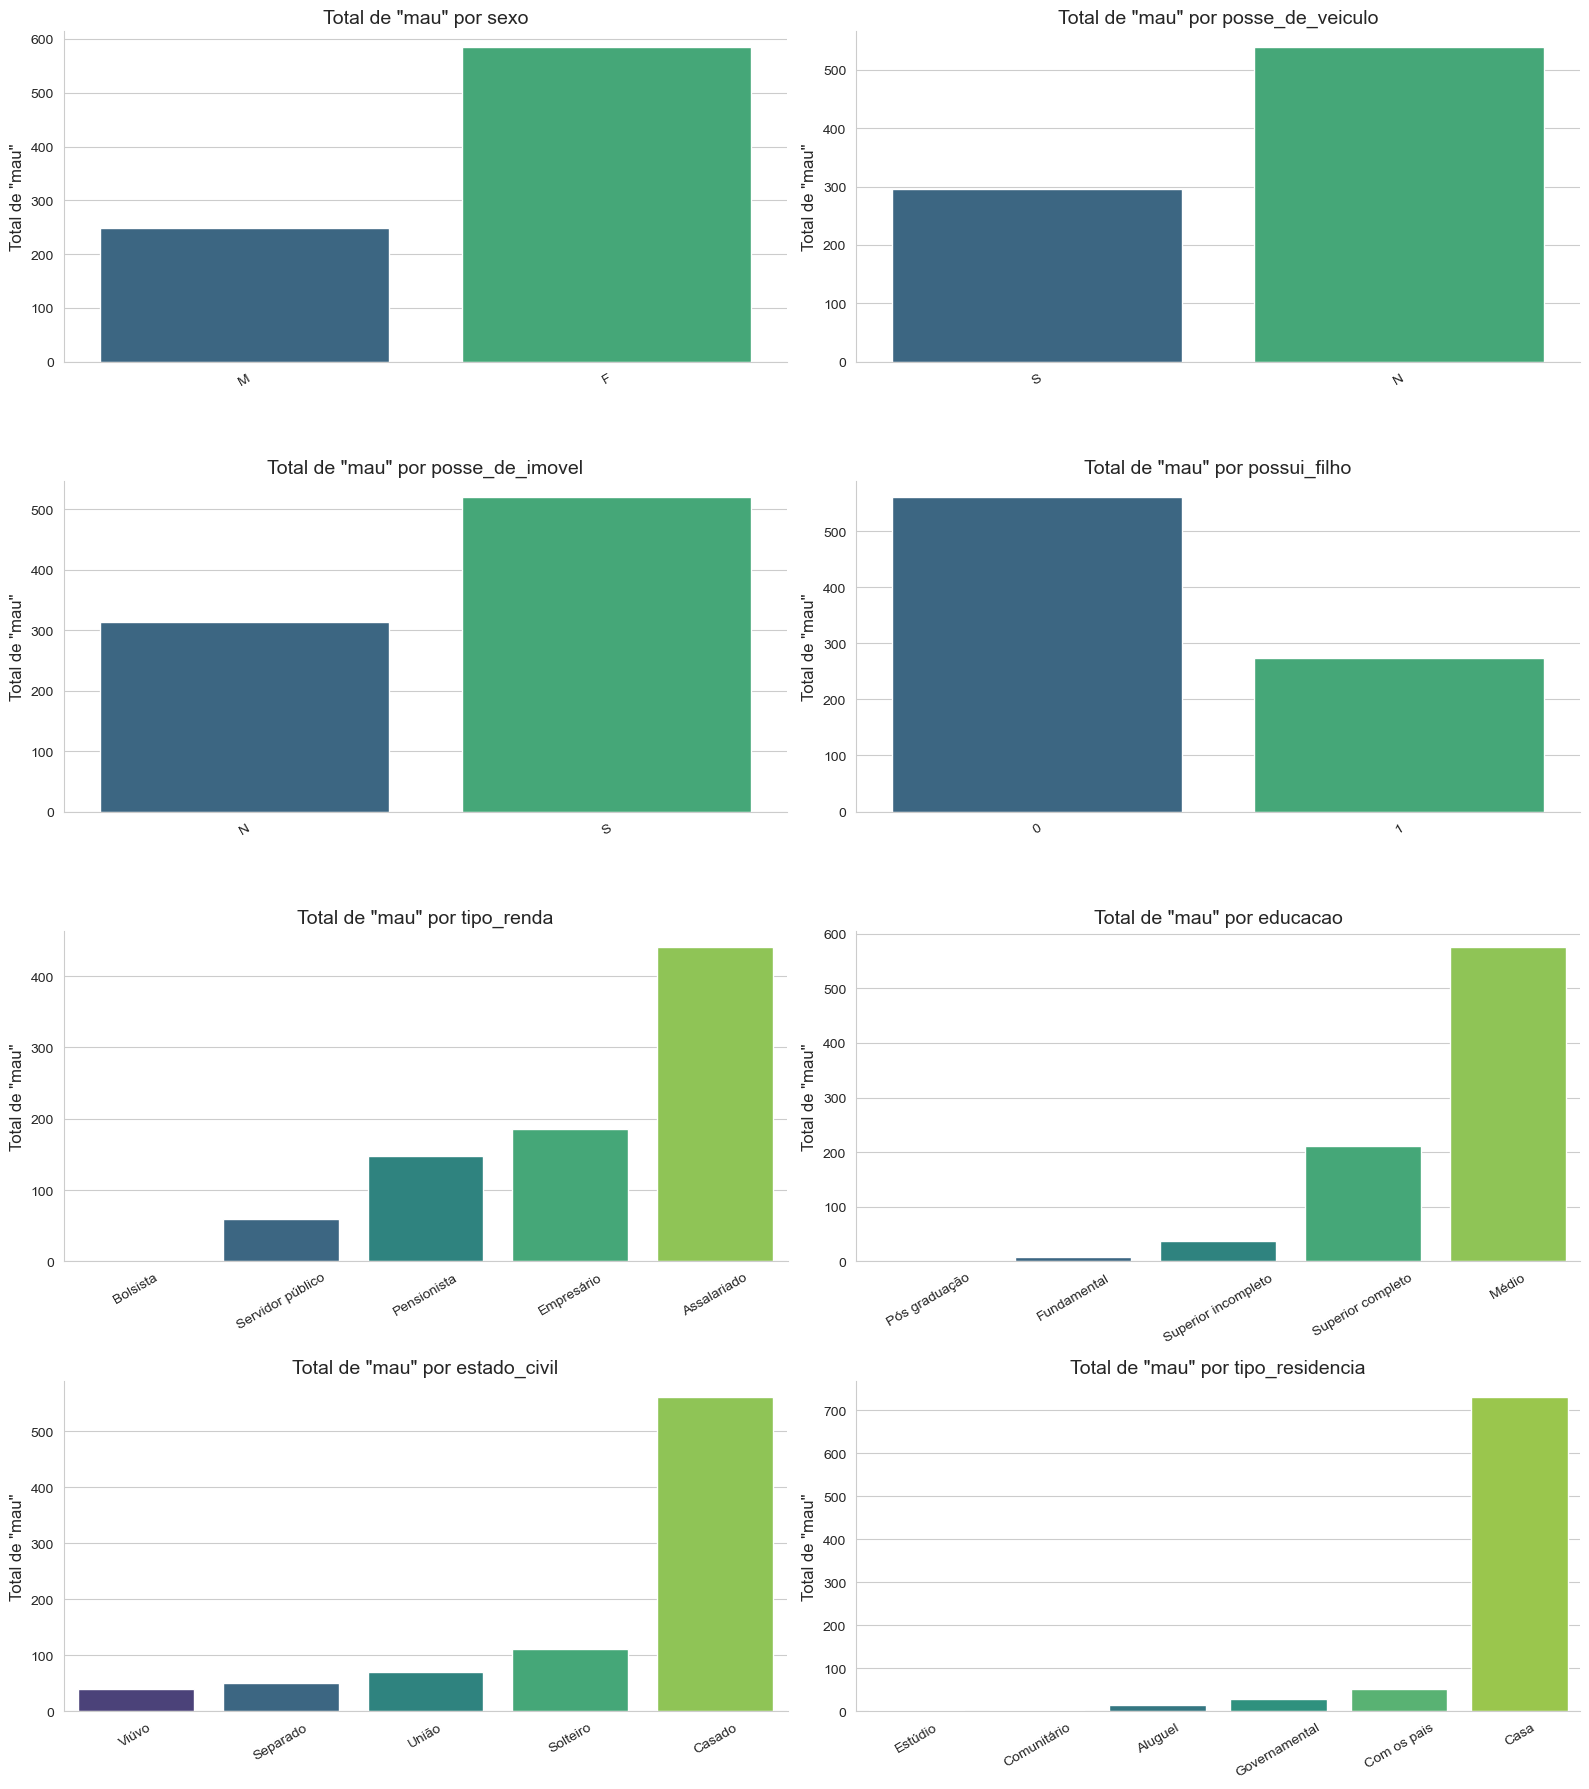

In [131]:
#categóricas
#valor absoluto
sns.set_style("whitegrid")  


df_sample = df.sample(10000, random_state=42)

categorical_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'possui_filho',
                    'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

fig, ax = plt.subplots(4, 2, figsize=(16, 18)) 
ax = ax.flatten() 


for i, var in enumerate(categorical_vars):
    counts = df_sample.groupby(var)['mau'].sum().sort_values() 
    sns.barplot(x=counts.index, y=counts.values, ax=ax[i], palette="viridis")

    ax[i].set_title(f'Total de "mau" por {var}', fontsize=14) 
    ax[i].set_xlabel('') 
    ax[i].set_ylabel('Total de "mau"', fontsize=12)
    ax[i].tick_params(axis='x', rotation=30)  #

plt.tight_layout()
sns.despine()

plt.show()


In [156]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,354527,31213,0.080917,Assalariado,385740,0.000439,0.081778,0.080057,-2.429950,-2.418434,-2.441578,0.037238,0.048754,0.025610
Bolsista,346,15,0.041551,Bolsista,361,0.010503,0.062207,0.020896,-3.138389,-2.713068,-3.847087,-0.671200,-0.245880,-1.379899
Empresário,159508,13204,0.076451,Empresário,172712,0.000639,0.077704,0.075198,-2.491574,-2.473957,-2.509458,-0.024386,-0.006769,-0.042270
Pensionista,115825,10440,0.082683,Pensionista,126265,0.000775,0.084202,0.081164,-2.406436,-2.386573,-2.426634,0.060752,0.080615,0.040555
Servidor público,61151,3771,0.058085,Servidor público,64922,0.000918,0.059884,0.056286,-2.786006,-2.753587,-2.819381,-0.318818,-0.286399,-0.352193


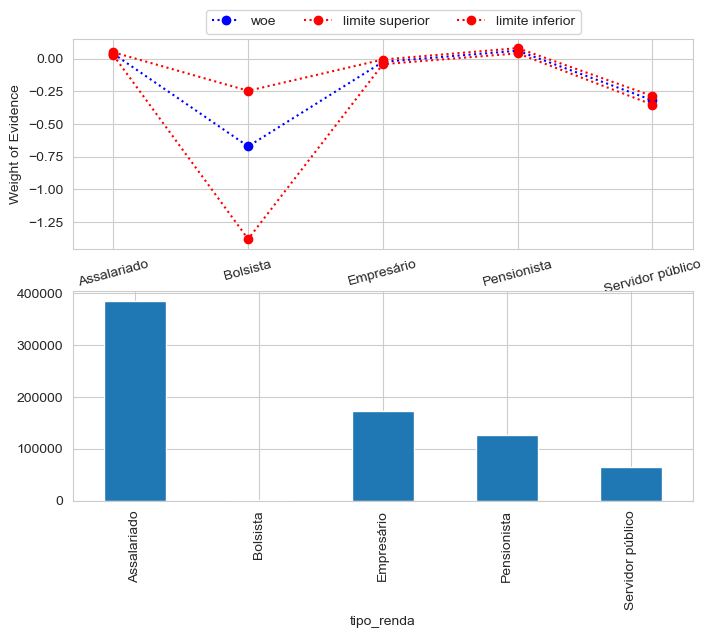

In [162]:
biv_discreta('tipo_renda', df)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,9416,933,0.090154,Aluguel,10349,0.002815,0.095672,0.084635,-2.311760,-2.246264,-2.380974,0.155428,0.220924,0.086214
Casa,622288,52006,0.077127,Casa,674294,0.000325,0.077763,0.076490,-2.482044,-2.473131,-2.491024,-0.014856,-0.005943,-0.023836
Com os pais,30086,3146,0.094668,Com os pais,33232,0.001606,0.097815,0.091520,-2.257928,-2.221736,-2.295214,0.209260,0.245452,0.171974
Comunitário,3012,278,0.084498,Comunitário,3290,0.004849,0.094006,0.074991,-2.382738,-2.265675,-2.512435,0.084450,0.201513,-0.045247
Estúdio,5042,353,0.065431,Estúdio,5395,0.003367,0.072031,0.058831,-2.659090,-2.555902,-2.772455,-0.191902,-0.088714,-0.305267
Governamental,21513,1927,0.082210,Governamental,23440,0.001794,0.085727,0.078693,-2.412693,-2.366968,-2.460235,0.054495,0.100221,0.006953


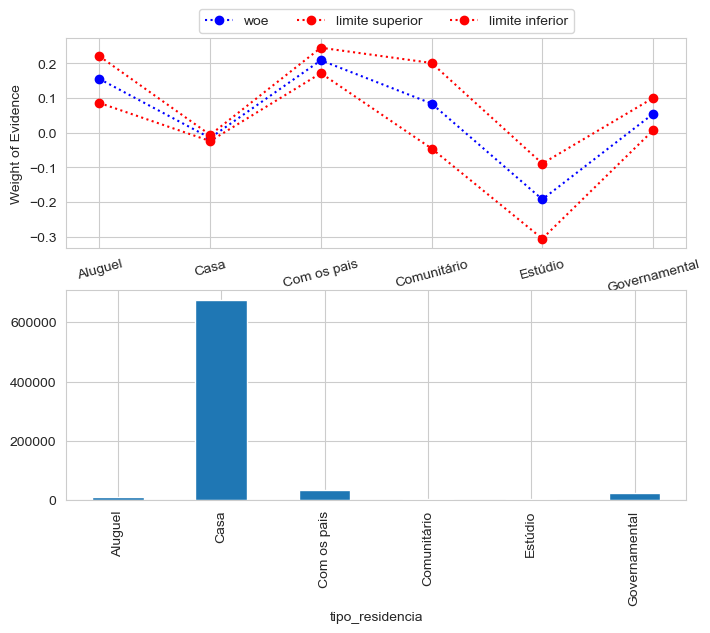

In [164]:
biv_discreta('tipo_residencia', df)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,7789,786,0.091662,Fundamental,8575,0.003116,0.097770,0.085554,-2.293511,-2.222252,-2.369175,0.173677,0.244936,0.098013
Médio,466106,40730,0.080361,Médio,506836,0.000382,0.081110,0.079613,-2.437448,-2.427364,-2.447619,0.029740,0.039824,0.019570
Pós graduação,753,59,0.072660,Pós graduação,812,0.009109,0.090541,0.054779,-2.546528,-2.307049,-2.848105,-0.079340,0.160139,-0.380917
Superior completo,189684,14622,0.071569,Superior completo,204306,0.000570,0.072687,0.070451,-2.562832,-2.546130,-2.579777,-0.095644,-0.078942,-0.112588
Superior incompleto,27025,2446,0.082997,Superior incompleto,29471,0.001607,0.086147,0.079847,-2.402308,-2.361619,-2.444427,0.064880,0.105569,0.022761


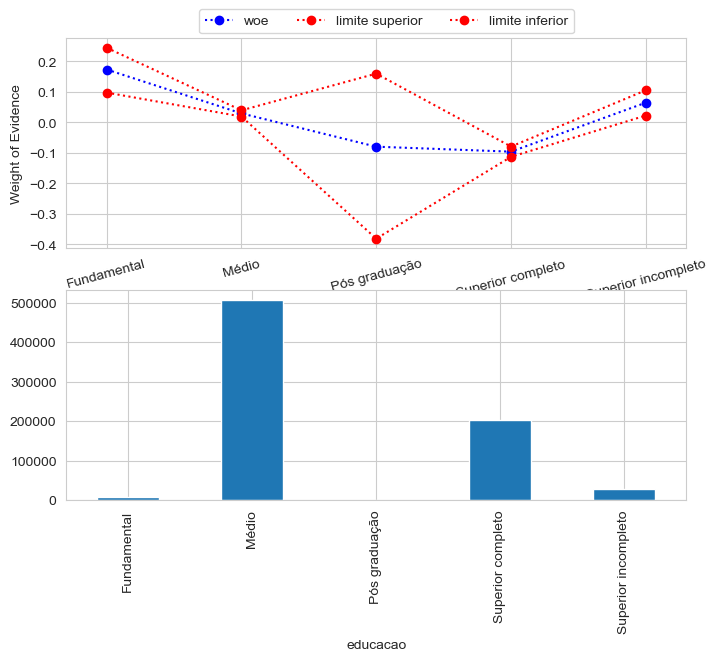

In [166]:
biv_discreta('educacao', df)

,qt_bom,qt_mau,mau,possui_filho,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
possui_filho,,,,,,,,,,,,,,
0,477683,39648,0.07664,0,517331,0.000370,0.077364,0.075915,-2.488907,-2.478707,-2.499195,-0.021719,-0.011519,-0.032007
1,213674,18995,0.08164,1,232669,0.000568,0.082752,0.080527,-2.420276,-2.405527,-2.435208,0.046912,0.061661,0.031980


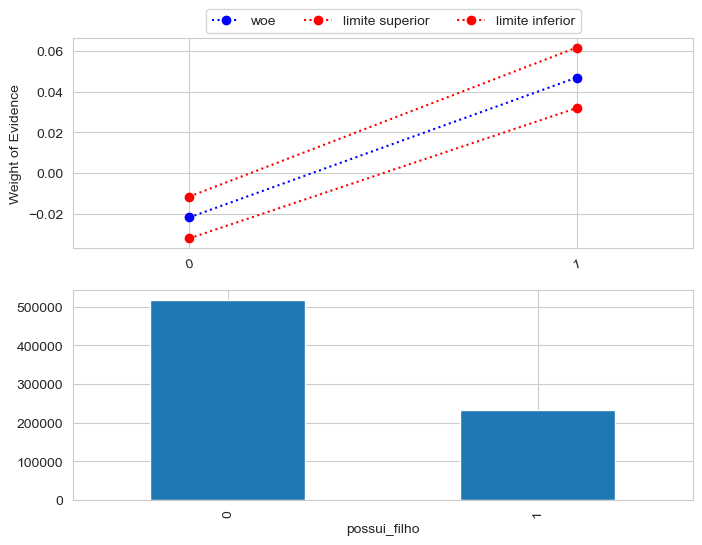

In [168]:
biv_discreta('possui_filho', df)

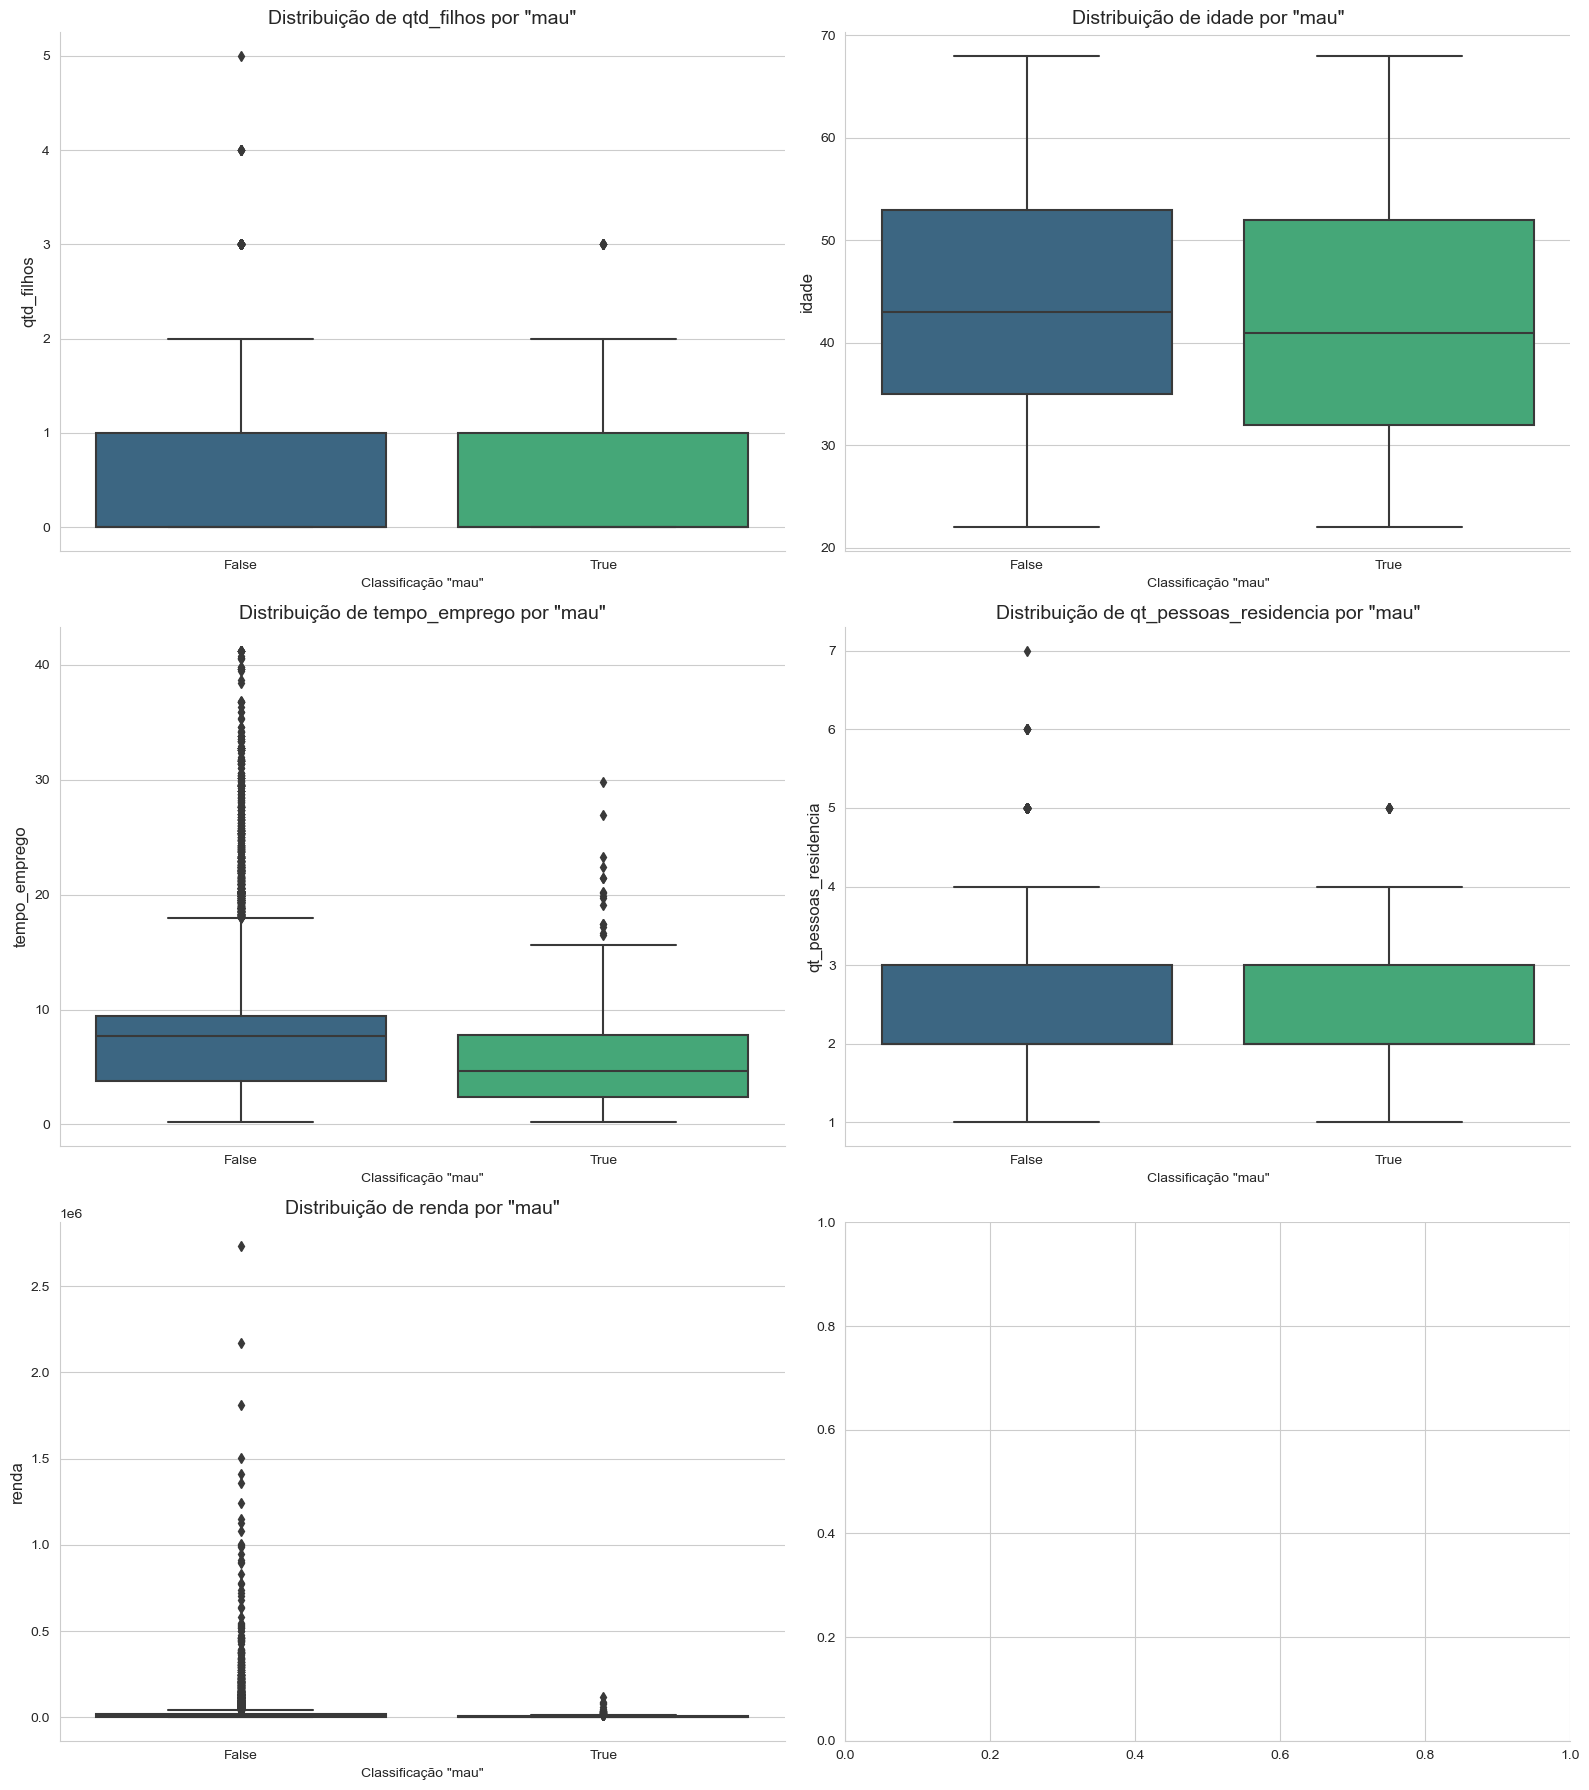

In [96]:
#numéricas
#valor absoluto
sns.set_style("whitegrid")  


df_sample = df.sample(10000, random_state=42)

num_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia','renda']

fig, ax = plt.subplots(3, 2, figsize=(16, 18)) 
ax = ax.flatten() 


for i, var in enumerate(num_vars):
    sns.boxplot(x='mau', y=var, data=df_sample, ax=ax[i], palette="viridis")
    ax[i].set_title(f'Distribuição de {var} por "mau"', fontsize=14) 
    ax[i].set_xlabel('Classificação "mau"')  
    ax[i].set_ylabel(var, fontsize=12)

plt.tight_layout()
sns.despine()

plt.show()


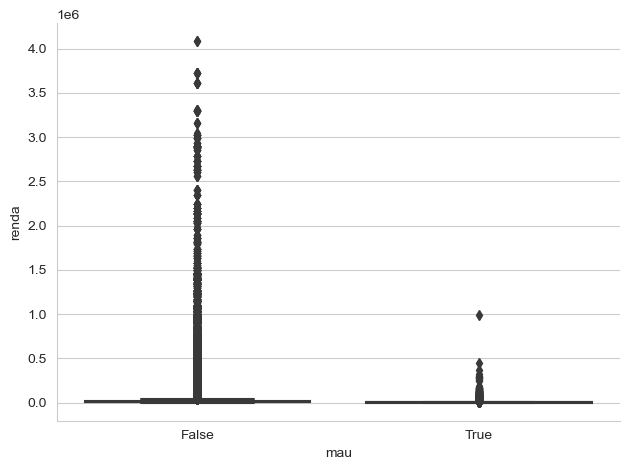

In [104]:
sns.set_style("whitegrid")  




sns.boxplot(x='mau', y='renda', data=df, palette="viridis")

plt.tight_layout()
sns.despine()

plt.show()


In [170]:

def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

/var/folders/z2/zc4h5d491c53jbts0kckp8s00000gn/T/ipykernel_24853/2120716600.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


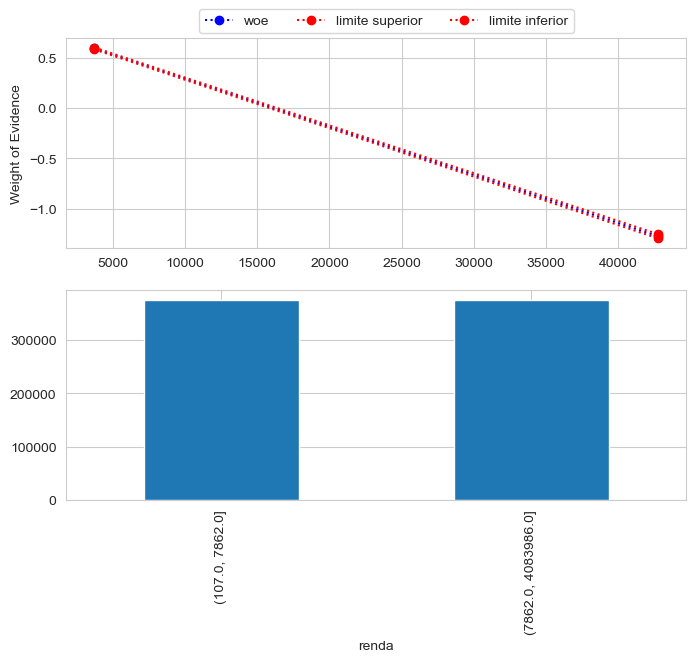

In [176]:
biv_continua('renda', 2, df)

/var/folders/z2/zc4h5d491c53jbts0kckp8s00000gn/T/ipykernel_24853/2120716600.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


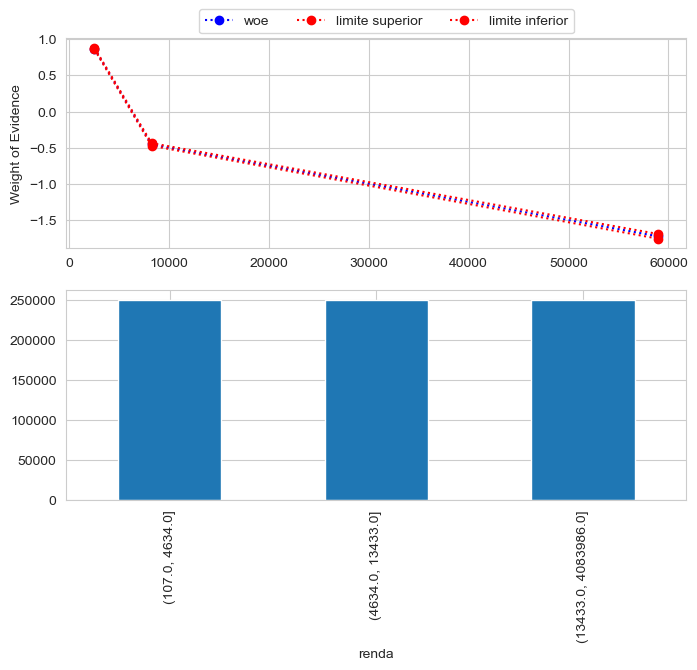

In [188]:
biv_continua('renda', 3, df)

/var/folders/z2/zc4h5d491c53jbts0kckp8s00000gn/T/ipykernel_24853/2120716600.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


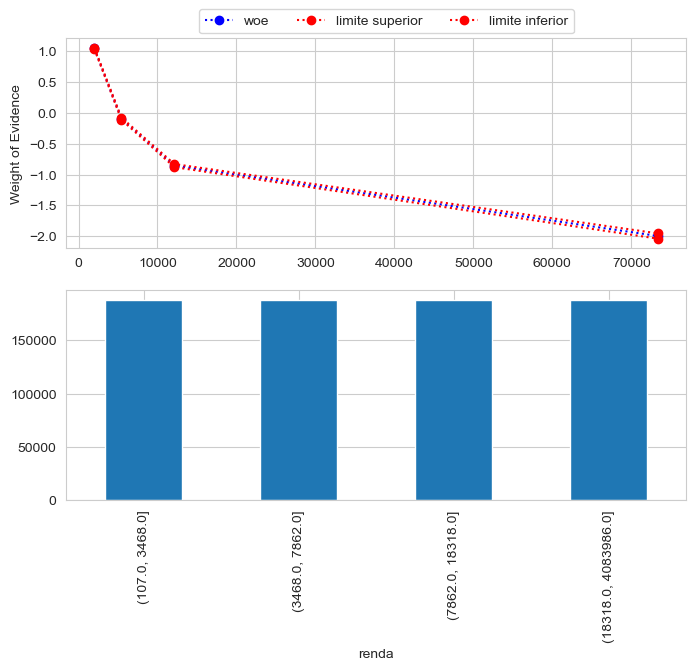

In [190]:
biv_continua('renda', 4, df)

/var/folders/z2/zc4h5d491c53jbts0kckp8s00000gn/T/ipykernel_24853/2120716600.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


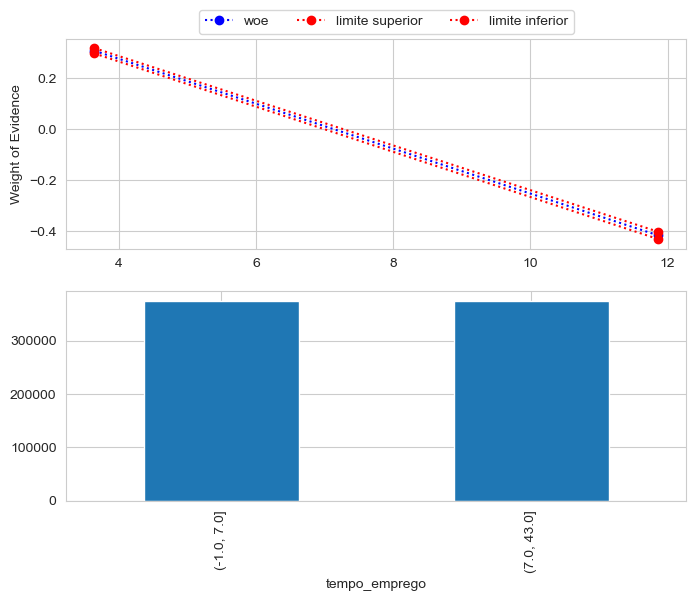

In [182]:
biv_continua('tempo_emprego', 2, df)

/var/folders/z2/zc4h5d491c53jbts0kckp8s00000gn/T/ipykernel_24853/2120716600.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


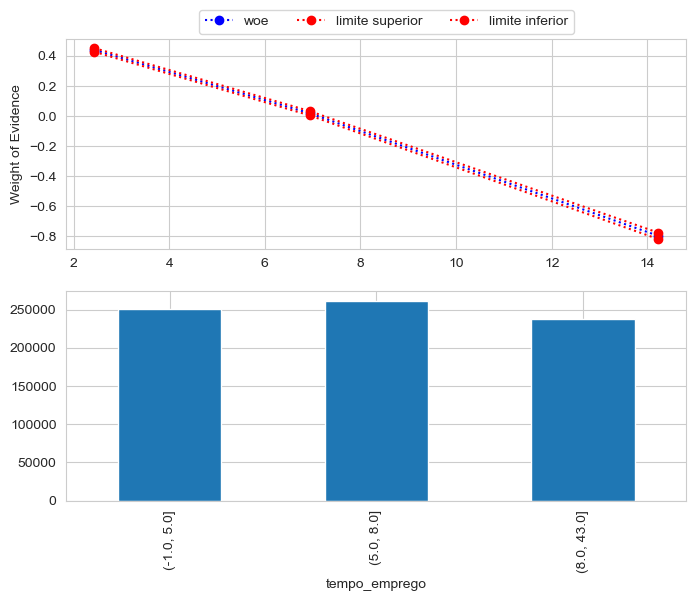

In [192]:
biv_continua('tempo_emprego', 3, df)

### Sobre a bivariada




- Categóricas:

A visualização das médias não disse muito, isso se deve pela variável mau estar desbalanceada. Tratando dos valores absolutos, são vistas diferenças entre as categorias. Entretanto, agrupamentos parecem bem-vindos. Ex.: tipo_residência = casa é muito superior as demais, as outras categorias poderiam ser agrupadas. O mesmo na variável educação, com o ensino médio. No momento, a intuição sobre as variáveis categóricas não seria o suficiente para determinar com clarezaa quais são as melhores preditivas.



- Numéricas:

- Em geral, as distribuições da variável "maus" é bem parecida. Destaque para as variáveis "tempo_emprego" e "renda" que possuem vários outliers e possuem ranges grandes (especialmente a renda, que está na escala de 10<sup>6</sup> ,ou seja, milhão)

Agrupamentos por patamares são bem-vindos: fiz testes de quebras nas duas variáveis e elas passaram a ser mais significativas, como visto acima.

# Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 
## Pré processamento


Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)


In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.covariance import EllipticEnvelope

#### Substituição de nulos

In [47]:
imputer = SimpleImputer(strategy='mean')

#### Remoção de Outliers

In [50]:
class EllipticEnvelopeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, contamination=0.1):
        self.contamination = contamination
        self.envelope = EllipticEnvelope(contamination=self.contamination, support_fraction=0.9)

    def fit(self, X, y=None):
        self.envelope.fit(X)
        return self

    def transform(self, X, y=None):
        return self.envelope.predict(X).reshape(-1, 1)

In [52]:
outliers_removal = EllipticEnvelopeTransformer(contamination=0.1)

#### Seleção de variáveis

In [55]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))

#### PCA

In [58]:
pca_pipe = PCA(n_components=5)

#### Criação de dummies

In [61]:
dummies = OneHotEncoder(handle_unknown='ignore')

#### Pipeline

In [212]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from pycaret.classification import *

numeric_features = ['renda','tempo_emprego','qt_pessoas_residencia','idade','qtd_filhos']
categorical_features = ['sexo','posse_de_veiculo','posse_de_imovel','tipo_renda','educacao','estado_civil','tipo_residencia']


numeric_transformer = Pipeline(steps=[
    ('imputer', imputer),
    ('outliere_removal', outliers_removal),   
])

categorical_transformer = Pipeline(steps=[
    ('dummy', dummies),
    ('feature_selector', feature_selector),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca_pipe),
                           ('log_reg', LogisticRegression(max_iter=200))
                          ])

pipe.fit(df2[variaveis].iloc[:,:-1], df2['mau'])

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='mean')),
                                                                  ('outliere_removal',
                                                                   EllipticEn...
                     n_oversamples=10, power_iteration_normalizer='auto',
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=200,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.

In [82]:
from pycaret.classification import *

In [226]:
dataset = df.sample(50000)

In [228]:
dataset.drop(['data_ref','index'], axis=1, inplace=True)

In [230]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [240]:
exp = ClassificationExperiment()

credit = exp.setup(
    data=data,
    target='mau',
    numeric_imputation='mean',
    normalize=True,           
    remove_outliers=True,     
    pca=True,                 
    pca_components=5,
    normalize_method='zscore', 
    transformation=True,
    transformation_method='quantile',
    fix_imbalance=True
)


,Description,Value
0,Session id,3667
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(72424, 6)"
5,Transformed train set shape,"(58174, 6)"
6,Transformed test set shape,"(14250, 6)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.9%


In [242]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7648,0.6970,0.4373,0.1517,0.2252,0.1235,0.1477
1,0.7660,0.7016,0.4509,0.1558,0.2316,0.1305,0.1564
2,0.7780,0.7013,0.4329,0.1600,0.2337,0.1349,0.1579
3,0.7842,0.6977,0.4212,0.1619,0.2339,0.1363,0.1575
4,0.7642,0.6888,0.4283,0.1491,0.2212,0.1190,0.1422
5,0.7680,0.6949,0.4334,0.1530,0.2261,0.1250,0.1486
6,0.7685,0.6918,0.4348,0.1536,0.2271,0.1261,0.1498
7,0.7653,0.6910,0.4385,0.1523,0.2261,0.1245,0.1488
8,0.7737,0.6969,0.4385,0.1582,0.2326,0.1329,0.1568


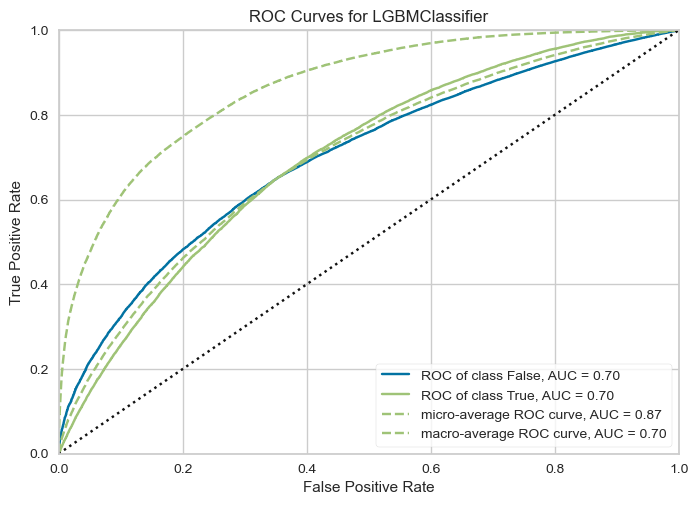

In [245]:
plot_model(lightgbm, plot = 'auc')

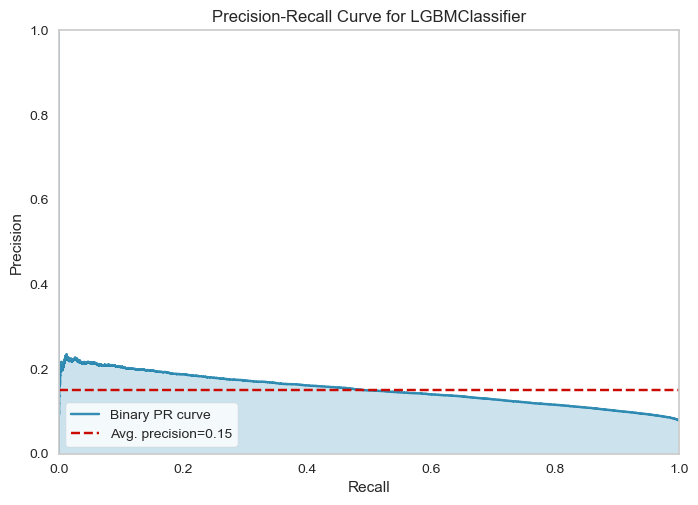

In [247]:
plot_model(lightgbm, plot = 'pr')

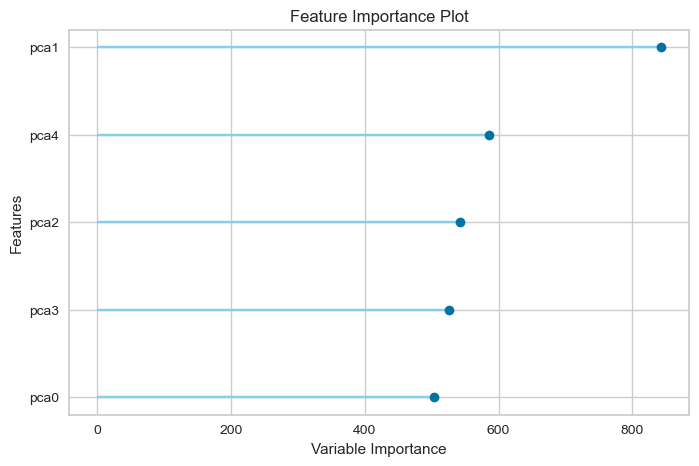

In [249]:
plot_model(lightgbm, plot='feature')

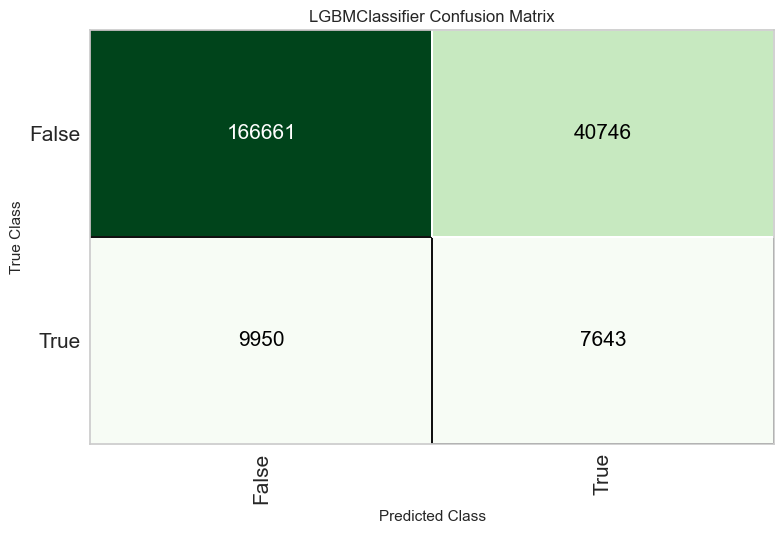

In [251]:
plot_model(lightgbm, plot = 'confusion_matrix')

In [253]:
predict_model(lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7747,0.7002,0.4344,0.1579,0.2317,0.1321,0.1555


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
118110,2015-03-01,955,M,N,S,1,Assalariado,Médio,Casado,Casa,26,3.671233,3.0,3470.310059,False,0,0.6012
205214,2015-05-01,16005,F,S,S,0,Assalariado,Médio,Casado,Casa,49,28.394520,2.0,332985.437500,False,0,0.9751
481999,2015-10-01,12890,F,N,N,0,Assalariado,Médio,Casado,Casa,48,29.484932,2.0,585069.687500,False,0,0.9678
391550,2015-08-01,11312,M,N,S,1,Assalariado,Médio,Casado,Casa,29,7.687671,3.0,12349.080078,False,0,0.8459
671599,2016-02-01,15687,F,N,S,0,Assalariado,Médio,Casado,Casa,53,6.016438,2.0,3378.270020,False,0,0.5112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412749,2015-09-01,15794,F,N,S,0,Empresário,Superior completo,Casado,Casa,31,6.852055,2.0,9656.469727,False,0,0.8238
331670,2015-07-01,9986,F,N,S,0,Assalariado,Médio,Solteiro,Casa,38,5.684931,1.0,4505.890137,False,0,0.8142
535328,2015-11-01,5773,M,S,N,0,Assalariado,Médio,Casado,Casa,49,9.545205,2.0,25615.720703,False,0,0.9218
82215,2015-02-01,8998,M,N,S,0,Servidor público,Médio,Casado,Aluguel,28,6.364384,2.0,10072.320312,False,0,0.9193


In [257]:
final_lightgbm = finalize_model(lightgbm)
print(lightgbm)

KeyboardInterrupt: 

In [259]:
save_model(lightgbm,'LGBM Model CREDIT SCORING 00000')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['data_ref'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['index', 'qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=Sim...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_ra

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.

### salvando o pipeline e o modelo

In [176]:
import pickle

with open('pipe_pre_credit_scoring.pkl', 'wb') as file:
    pickle.dump(pipe, file)
print("Pipeline salvo!")

Pipeline salvo!


In [152]:
import pickle

with open('final_lgmb_credit_scoring.pkl', 'wb') as file:
    pickle.dump(final_lightgbm, file)
print("Modelo salvo com pickle!")

Modelo salvo com pickle!


In [164]:
from joblib import load

with open('pipeline_credit_scoring.pkl', 'rb') as f:
    pipe = load(f, mmap_mode='r')